<a href="https://colab.research.google.com/github/SrinivasVeshala/ENHANCING-OPINION-MINING-THROUGH-SUPERVISED-LEARNING/blob/main/software_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

import os
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib_venn import venn2
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm


import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
folder_path = os.getcwd()
files_to_load = ["amazon_cells_labelled.txt", "imdb_labelled.txt", "yelp_labelled.txt"]
dataframes = []

for file_name in files_to_load:
    file_path = os.path.join(folder_path, file_name)

    df = pd.read_csv(file_path, sep='\t', header=None, names=['text', 'label'])
    df['source'] = file_name.split('_')[0]  # Optional: add source (amazon, imdb, yelp)
    dataframes.append(df)

full_data = pd.concat(dataframes, ignore_index=True)


display(full_data.head(10))
display("Total samples:", len(full_data))
display("Class distribution:\n", full_data['label'].value_counts())

,text,label,source
0,So there is no way for me to plug it in here i...,0,amazon
1,"Good case, Excellent value.",1,amazon
2,Great for the jawbone.,1,amazon
3,Tied to charger for conversations lasting more...,0,amazon
4,The mic is great.,1,amazon
5,I have to jiggle the plug to get it to line up...,0,amazon
6,If you have several dozen or several hundred c...,0,amazon
7,If you are Razr owner...you must have this!,1,amazon
8,"Needless to say, I wasted my money.",0,amazon
9,What a waste of money and time!.,0,amazon


'Total samples:'

2748

'Class distribution:\n'

,count
label,
1,1386
0,1362


In [5]:
# Vectorizer setup
vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words='english'
)

# Apply TF-IDF to the text column
X_tfidf = vectorizer.fit_transform(full_data['text'])  # X_tfidf is a sparse matrix
feature_names = vectorizer.get_feature_names_out()

# Optional: convert to DataFrame for analysis/visualization
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=feature_names)

# Show preview
tfidf_df.head()

,00,10,100,11,12,13,15,15g,15pm,17,...,yucky,yukon,yum,yummy,yun,z500a,zero,zillion,zombie,zombiez
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Visualization 1: Top 20 Words by Mean TF-IDF

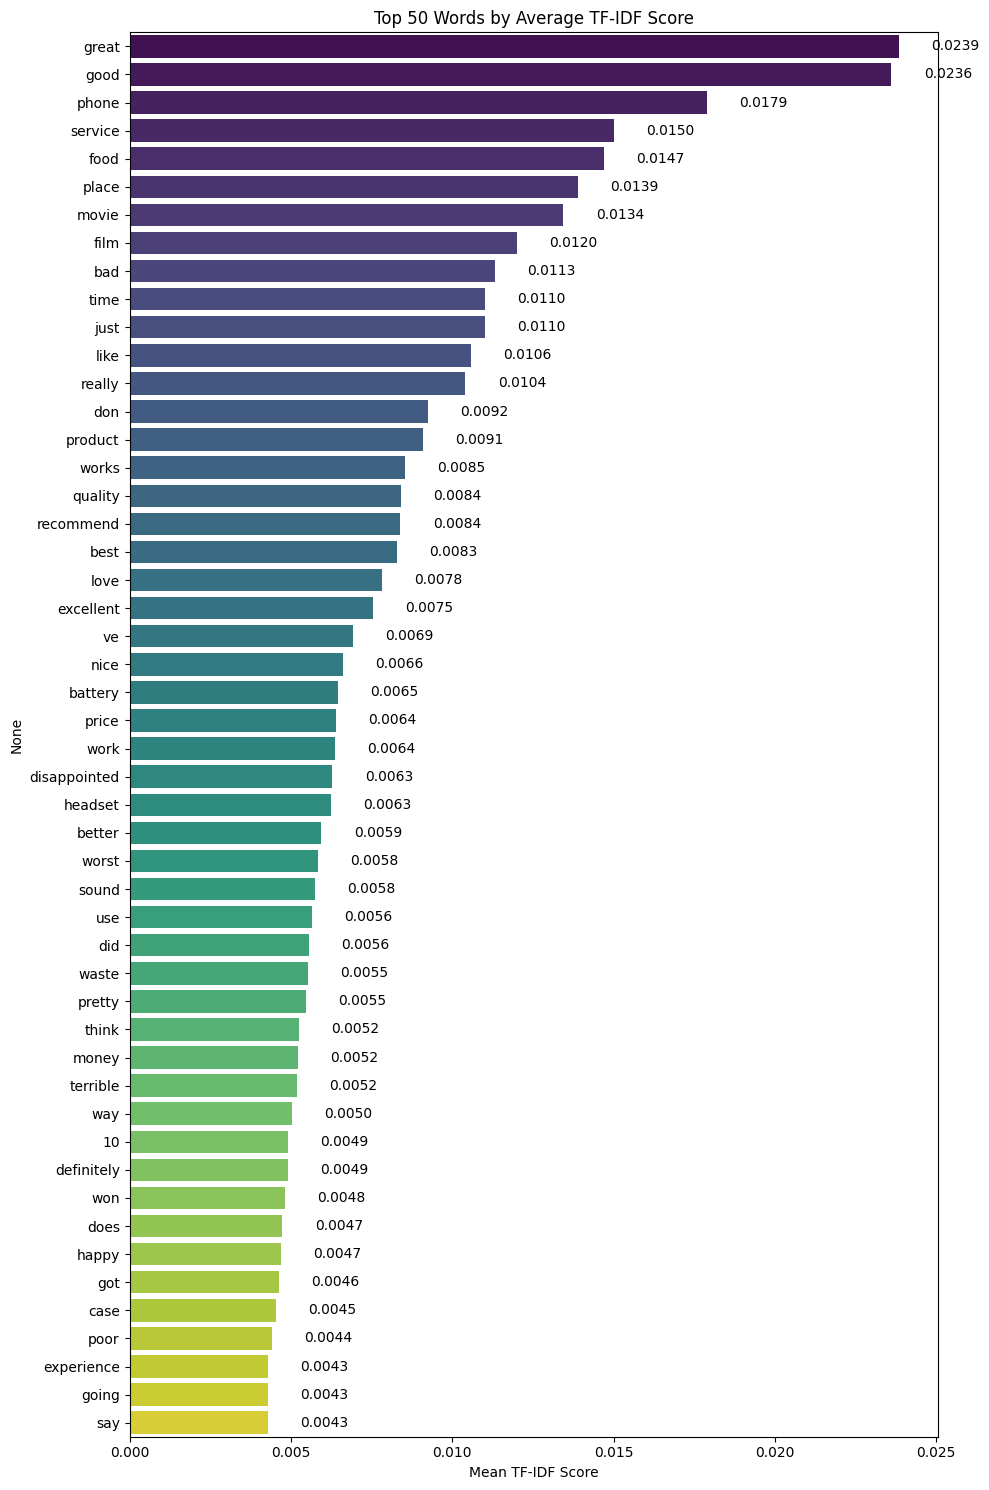

In [6]:
mean_tfidf = tfidf_df.mean().sort_values(ascending=False).head(50)
plt.figure(figsize=(10,15))
ax = sns.barplot(x=mean_tfidf.values, y=mean_tfidf.index, palette="viridis")
for i, v in enumerate(mean_tfidf.values):
    ax.text(v + 0.001, i, f"{v:.4f}", color='black', va='center')
plt.title("Top 50 Words by Average TF-IDF Score")
plt.xlabel("Mean TF-IDF Score")
plt.tight_layout()
plt.show()

### WordCloud for Positive Sentiment

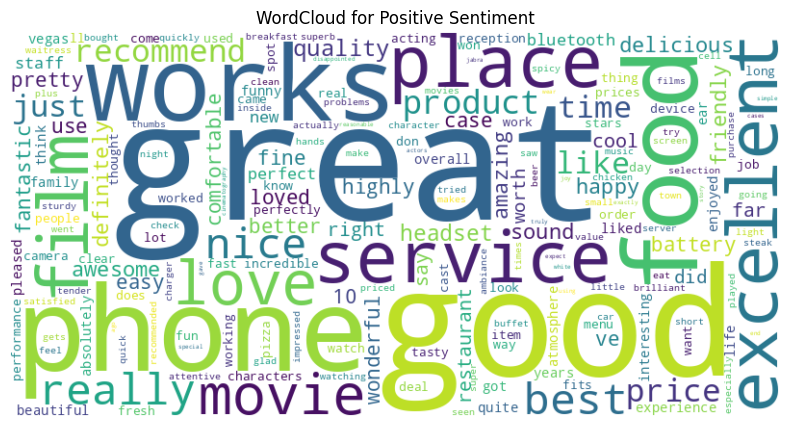

In [7]:
pos_indices = full_data[full_data['label'] == 1].index
pos_tfidf = tfidf_df.iloc[pos_indices].mean().sort_values(ascending=False)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(pos_tfidf)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud for Positive Sentiment")
plt.show()

### WordCloud for Negative Sentiment

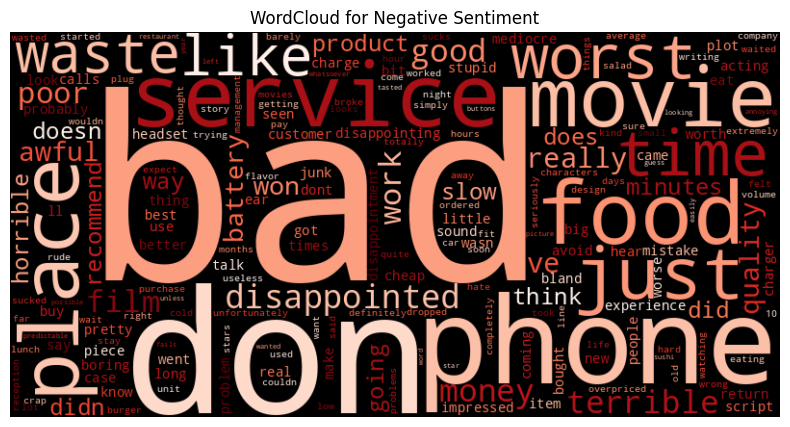

In [8]:
neg_indices = full_data[full_data['label'] == 0].index
neg_tfidf = tfidf_df.iloc[neg_indices].mean().sort_values(ascending=False)
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate_from_frequencies(neg_tfidf)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud for Negative Sentiment")
plt.show()

### PCA of TF-IDF Matrix

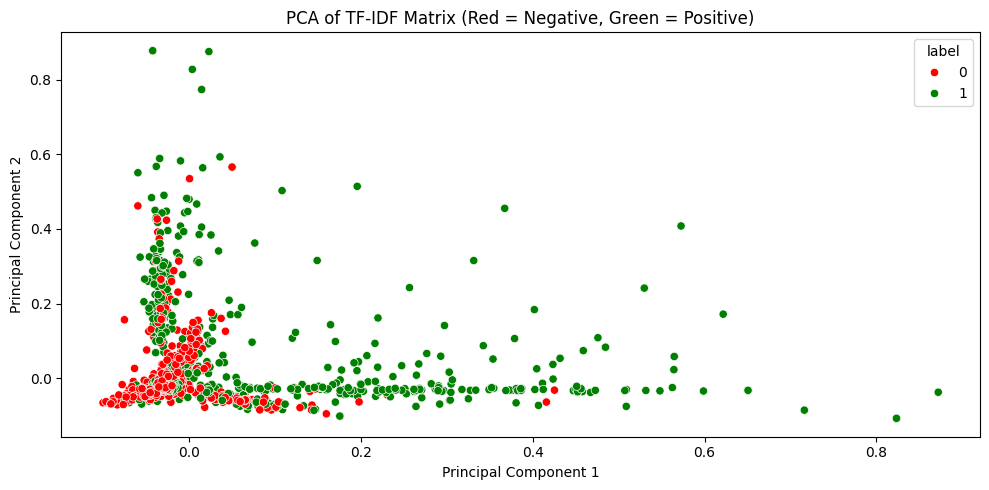

In [9]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(tfidf_df)
plt.figure(figsize=(10,5))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=full_data['label'], palette={0:'red', 1:'green'})
plt.title("PCA of TF-IDF Matrix (Red = Negative, Green = Positive)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.tight_layout()
plt.show()

### TF-IDF Words in Positive vs Negative Reviews

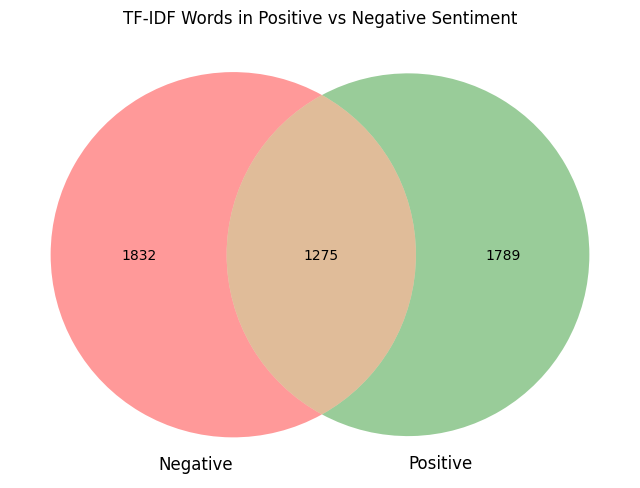

In [10]:
pos_indices = full_data[full_data['label'] == 1].index
neg_indices = full_data[full_data['label'] == 0].index
# Get all words with non-zero average TF-IDF in each class
pos_words = set(tfidf_df.iloc[pos_indices].mean()[lambda x: x > 0].index)
neg_words = set(tfidf_df.iloc[neg_indices].mean()[lambda x: x > 0].index)
plt.figure(figsize=(8,6))
venn2([neg_words, pos_words], set_labels=("Negative", "Positive"))
plt.title("TF-IDF Words in Positive vs Negative Sentiment")
plt.show()

In [11]:
binary_tfidf = tfidf_df.gt(0).astype(int)
pos_indices = full_data[full_data['label'] == 1].index
neg_indices = full_data[full_data['label'] == 0].index
pos_freq = binary_tfidf.iloc[pos_indices].sum()
neg_freq = binary_tfidf.iloc[neg_indices].sum()
total_freq = binary_tfidf.sum()
freq_df = pd.DataFrame({
    'Frequency_Positive': pos_freq,
    'Frequency_Negative': neg_freq,
    'Frequency_Total': total_freq
})
freq_df = freq_df.sort_values(by='Frequency_Total', ascending=False)
freq_df.head(10)

,Frequency_Positive,Frequency_Negative,Frequency_Total
good,160,50,210
great,180,11,191
phone,84,75,159
movie,67,66,133
film,79,47,126
food,59,62,121
place,56,55,111
like,51,59,110
service,55,53,108
time,49,58,107


### Top 30 Words by Total Frequency

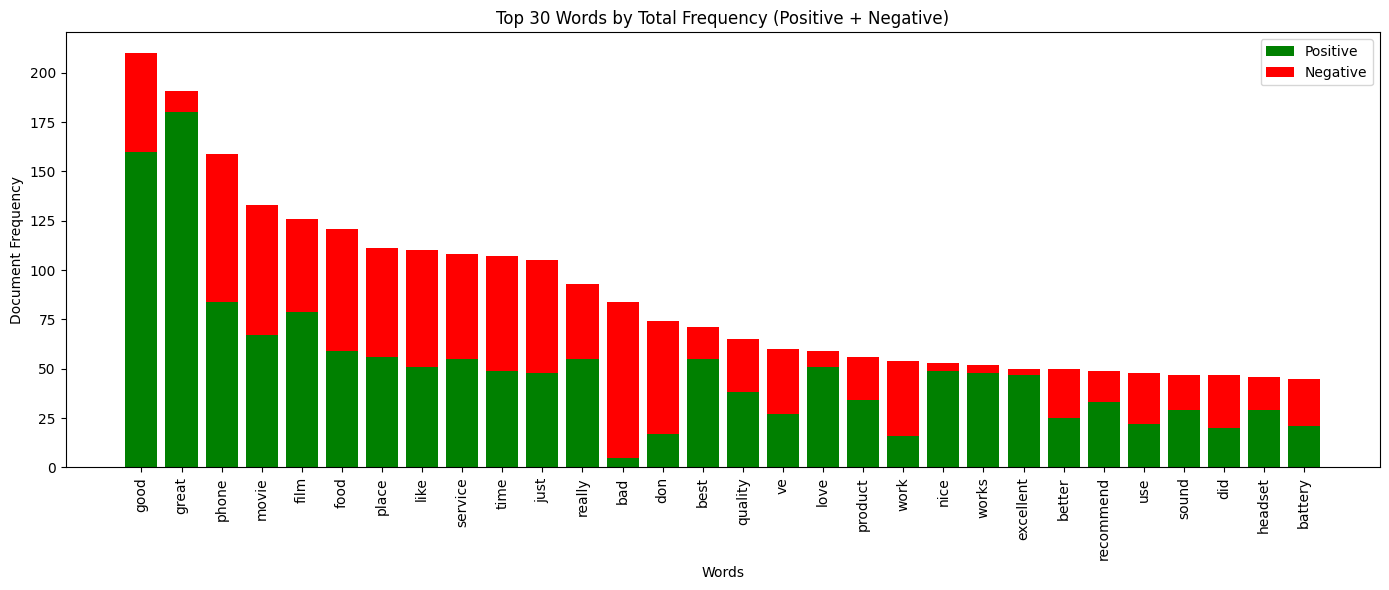

In [12]:
top = freq_df.sort_values('Frequency_Total', ascending=False).head(30)
plt.figure(figsize=(14,6))
plt.bar(top.index, top['Frequency_Positive'], color='green', label='Positive')
plt.bar(top.index, top['Frequency_Negative'], bottom=top['Frequency_Positive'], color='red', label='Negative')
plt.xlabel("Words")
plt.ylabel("Document Frequency")
plt.title("Top 30 Words by Total Frequency (Positive + Negative)")
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, full_data['label'], test_size=0.2, random_state=42)

Logistic Regression Grid Search: 100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


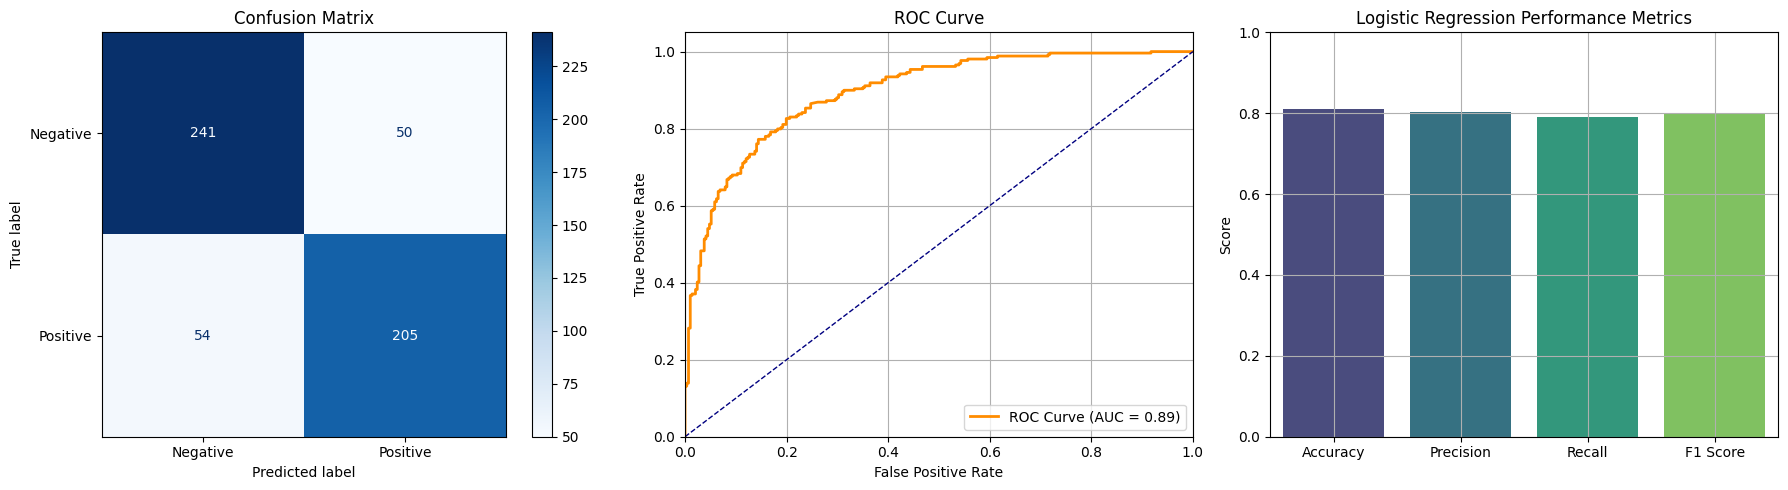

Best Parameters (Logistic Regression): {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy: 0.8109090909090909
Precision: 0.803921568627451
Recall: 0.7915057915057915
F1 Score: 0.7976653696498055


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ParameterGrid, cross_val_score
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np

# Define parameter grid for Logistic Regression
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['liblinear', 'lbfgs']
}

grid = list(ParameterGrid(param_grid_lr))
best_score = -1
best_params = None
best_model = None

# Manual grid search with tqdm
for params in tqdm(grid, desc="Logistic Regression Grid Search"):
    model = LogisticRegression(**params, max_iter=1000)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1', n_jobs=-1)
    mean_score = np.mean(scores)
    if mean_score > best_score:
        best_score = mean_score
        best_params = params
        best_model = model

# Fit best model
best_model.fit(X_train, y_train)

# Predictions
y_pred_lr = best_model.predict(X_test)
y_probs_lr = best_model.predict_proba(X_test)[:, 1]

# Metrics
accuracy_lr = accuracy_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
confusion_lr = confusion_matrix(y_test, y_pred_lr)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_probs_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Confusion Matrix
ConfusionMatrixDisplay(confusion_lr, display_labels=['Negative', 'Positive']).plot(
    ax=axes[0], cmap="Blues", values_format='d'
)
axes[0].set_title("Confusion Matrix")

# 2. ROC Curve
axes[1].plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc_lr:.2f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend(loc="lower right")
axes[1].grid(True)

# 3. Bar Plot of Metrics
metrics_lr = {
    'Accuracy': accuracy_lr,
    'Precision': precision_lr,
    'Recall': recall_lr,
    'F1 Score': f1_lr
}
sns.barplot(ax=axes[2], x=list(metrics_lr.keys()), y=list(metrics_lr.values()), palette='viridis')
axes[2].set_ylim(0, 1)
axes[2].set_title("Logistic Regression Performance Metrics")
axes[2].set_ylabel("Score")
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Output
print("Best Parameters (Logistic Regression):", best_params)
print("Accuracy:", accuracy_lr)
print("Precision:", precision_lr)
print("Recall:", recall_lr)
print("F1 Score:", f1_lr)


Random Forest Grid Search: 100%|██████████| 18/18 [01:09<00:00,  3.85s/it]


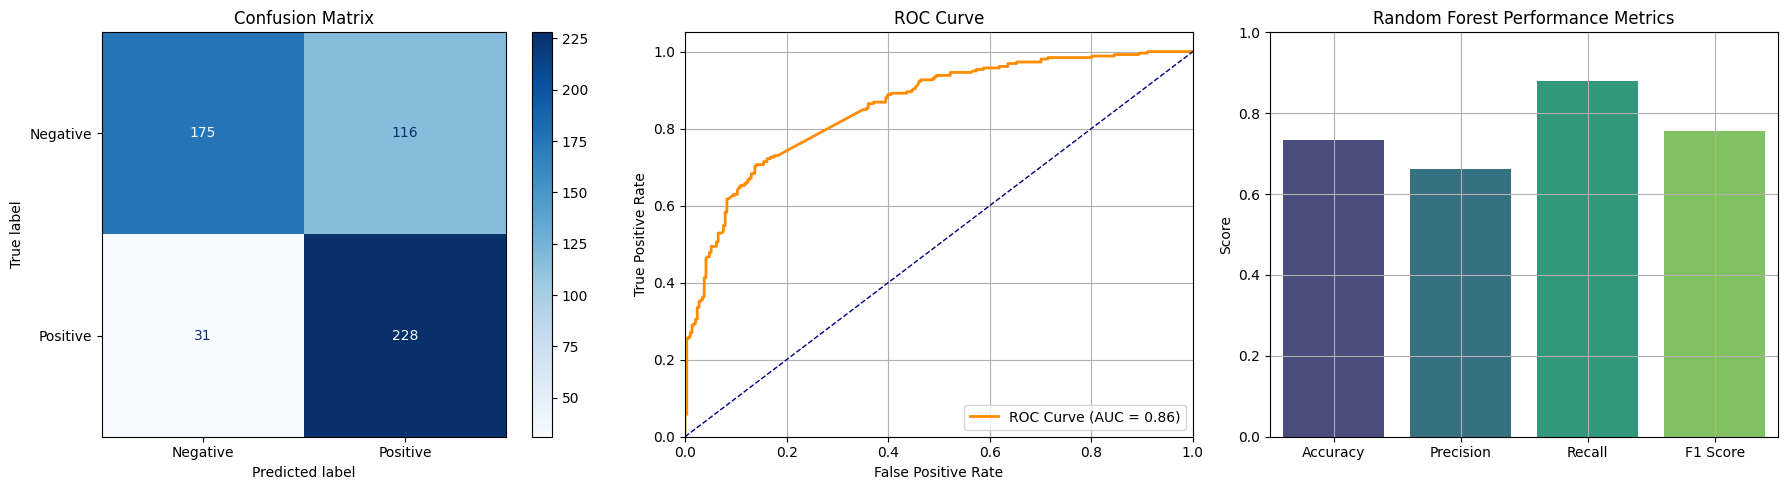

Best Parameters (Random Forest): {'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 75}
Accuracy: 0.7327272727272728
Precision: 0.6627906976744186
Recall: 0.8803088803088803
F1 Score: 0.7562189054726368


In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid, cross_val_score
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np

# Define model and parameter grid
param_grid_rf = {
    'n_estimators': np.linspace(50, 100, 3, dtype=int).tolist(),
    'max_depth': [None] + np.linspace(5, 15, 2, dtype=int).tolist(),
    'min_samples_split': np.linspace(2, 10, 2, dtype=int).tolist()
}

grid = list(ParameterGrid(param_grid_rf))
best_score = -1
best_params = None
best_model = None

# Manual grid search with tqdm progress bar
for params in tqdm(grid, desc="Random Forest Grid Search"):
    model = RandomForestClassifier(**params, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1', n_jobs=-1)
    mean_score = np.mean(scores)
    if mean_score > best_score:
        best_score = mean_score
        best_params = params
        best_model = model

# Fit best model on full training set
best_model.fit(X_train, y_train)

# Predictions
y_pred_rf = best_model.predict(X_test)
y_probs_rf = best_model.predict_proba(X_test)[:, 1]

# Metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
confusion_rf = confusion_matrix(y_test, y_pred_rf)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_probs_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Confusion Matrix
ConfusionMatrixDisplay(confusion_rf, display_labels=['Negative', 'Positive']).plot(
    ax=axes[0], cmap="Blues", values_format='d'
)
axes[0].set_title("Confusion Matrix")

# 2. ROC Curve
axes[1].plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc_rf:.2f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend(loc="lower right")
axes[1].grid(True)

# 3. Bar Plot of Metrics
metrics_rf = {
    'Accuracy': accuracy_rf,
    'Precision': precision_rf,
    'Recall': recall_rf,
    'F1 Score': f1_rf
}
sns.barplot(ax=axes[2], x=list(metrics_rf.keys()), y=list(metrics_rf.values()), palette='viridis')
axes[2].set_ylim(0, 1)
axes[2].set_title("Random Forest Performance Metrics")
axes[2].set_ylabel("Score")
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Output
print("Best Parameters (Random Forest):", best_params)
print("Accuracy:", accuracy_rf)
print("Precision:", precision_rf)
print("Recall:", recall_rf)
print("F1 Score:", f1_rf)

SVM Grid Search: 100%|██████████| 16/16 [01:34<00:00,  5.90s/it]


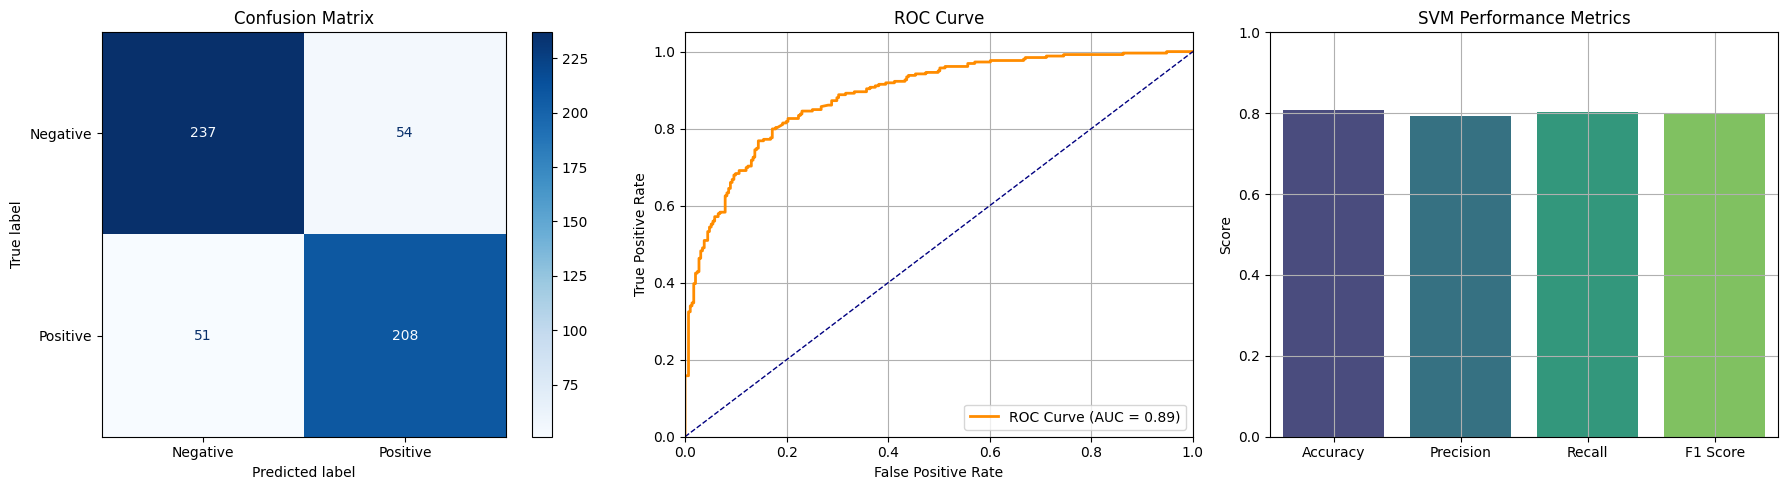

Best Parameters (SVM): {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Accuracy: 0.8090909090909091
Precision: 0.7938931297709924
Recall: 0.803088803088803
F1 Score: 0.7984644913627639


In [16]:
from sklearn.svm import SVC

# Define parameter grid for SVM

param_grid_svm = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}
grid = list(ParameterGrid(param_grid_svm))
best_score = -1
best_params = None
best_model = None
# Manual grid search with tqdm
for params in tqdm(grid, desc="SVM Grid Search"):
    model = SVC(**params, probability=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1', n_jobs=-1)
    mean_score = np.mean(scores)
    if mean_score > best_score:
        best_score = mean_score
        best_params = params
        best_model = model
# Fit best model on full training set
best_model.fit(X_train, y_train)
# Predictions
y_pred_svm = best_model.predict(X_test)
y_probs_svm = best_model.predict_proba(X_test)[:, 1]
# Metrics
accuracy_svm = accuracy_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
confusion_svm = confusion_matrix(y_test, y_pred_svm)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_probs_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)
# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
# 1. Confusion Matrix
ConfusionMatrixDisplay(confusion_svm, display_labels=['Negative', 'Positive']).plot(
    ax=axes[0], cmap="Blues", values_format='d'
)
axes[0].set_title("Confusion Matrix")
# 2. ROC Curve
axes[1].plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc_svm:.2f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend(loc="lower right")
axes[1].grid(True)
# 3. Bar Plot of Metrics
metrics_svm = {
    'Accuracy': accuracy_svm,
    'Precision': precision_svm,
    'Recall': recall_svm,
    'F1 Score': f1_svm
}
sns.barplot(ax=axes[2], x=list(metrics_svm.keys()), y=list(metrics_svm.values()), palette='viridis')
axes[2].set_ylim(0, 1)
axes[2].set_title("SVM Performance Metrics")
axes[2].set_ylabel("Score")
axes[2].grid(True)
plt.tight_layout()
plt.show()
# Output
print("Best Parameters (SVM):", best_params)
print("Accuracy:", accuracy_svm)
print("Precision:", precision_svm)
print("Recall:", recall_svm)
print("F1 Score:", f1_svm)

In [17]:
# Create and round the comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'SVM'],
    'Accuracy': [accuracy_lr, accuracy_rf, accuracy_svm],
    'Precision': [precision_lr, precision_rf, precision_svm],
    'Recall': [recall_lr, recall_rf, recall_svm],
    'F1 Score': [f1_lr, f1_rf, f1_svm],
    'ROC AUC': [roc_auc_lr, roc_auc_rf, roc_auc_svm]
}).set_index('Model').round(4)

# Sort primarily by F1 Score, then ROC AUC
sorted_df = comparison_df.sort_values(by=['F1 Score', 'ROC AUC'], ascending=False)

# Display with green gradient on F1 Score
styled_df = sorted_df.style.format("{:.4f}").background_gradient(subset=['F1 Score'], cmap='Greens')
display(styled_df)

# Show best model name
best_model_name = sorted_df.index[0]
print("Best model based on F1 Score:", best_model_name)


,Accuracy,Precision,Recall,F1 Score,ROC AUC
Model,,,,,
SVM,0.8091,0.7939,0.8031,0.7985,0.8865
Logistic Regression,0.8109,0.8039,0.7915,0.7977,0.8938
Random Forest,0.7327,0.6628,0.8803,0.7562,0.8564


Best model based on F1 Score: SVM
